# Hyperparameters exploration via SOMs vectorization

In Self-Organizing Maps, hyperparameters like the neighborhood size or the learning rate are not easy to fine tune. It is often a process of trials and errors that need multiple iterations. To facilitate this exploration, `somap` SOMs can be vectorized along multiple axis to test in parallel the combination of different hyperparameters.

Here is an example testing the combination of multiple `sigma` and `alpha` values for a simple static Kohonen SOM:


In [1]:
# Imports
import equinox as eqx
import jax.numpy as jnp
import somap as smp
from array2image import array_to_image  # to easily vizualize the results

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
# Load the MNIST dataset as a Numpy array of shape (60000, 28, 28)
data = smp.datasets.MNIST().data

In [3]:
# Vectorize over the two hyperparamters of StaticKsom
@eqx.filter_vmap(in_axes=(None, 0))
@eqx.filter_vmap(in_axes=(0, None))
def myArrayOfStaticKsom(sigma, alpha):
    return smp.StaticKsom(
        shape=(10, 10),
        topography="square",
        borderless=True,
        input_shape=(28, 28),
        params=smp.StaticKsomParams(sigma=sigma, alpha=alpha),
    )


# List of hyperparameters to test
sigmas = jnp.linspace(0.05, 0.2, 4)
alphas = jnp.linspace(0.001, 0.05, 3)

model = myArrayOfStaticKsom(sigmas, alphas)
model

StaticKsom(
  shape=(10, 10),
  topography='square',
  borderless=True,
  input_shape=(28, 28),
  params=StaticKsomParams(sigma=f32[3,4], alpha=f32[3,4]),
  metrics=True,
  debug=False,
  algo=SomAlgo(
    f_dist=EuclidianDist(),
    f_nbh=GaussianNbh(sigma=f32[3,4]),
    f_lr=ConstantLr(alpha=f32[3,4]),
    f_update=SomUpdate()
  ),
  in_size=784,
  t=i32[3,4],
  w_bu=f32[3,4,10,10,28,28],
  i_act_nb=i32[3,4,10,10],
  winner=i32[3,4,2]
)

In [4]:
# Vectorize the `make_steps` functions over all 'Array' params of our model
@eqx.filter_vmap(in_axes=(eqx.if_array(0), None))
@eqx.filter_vmap(in_axes=(eqx.if_array(0), None))
def make_steps(model, inputs):
    return smp.make_steps(model, inputs)

In [5]:
# Run our 3x4 SOMs on the 60k MNIST images
model, aux = make_steps(model, {"bu_v": data})

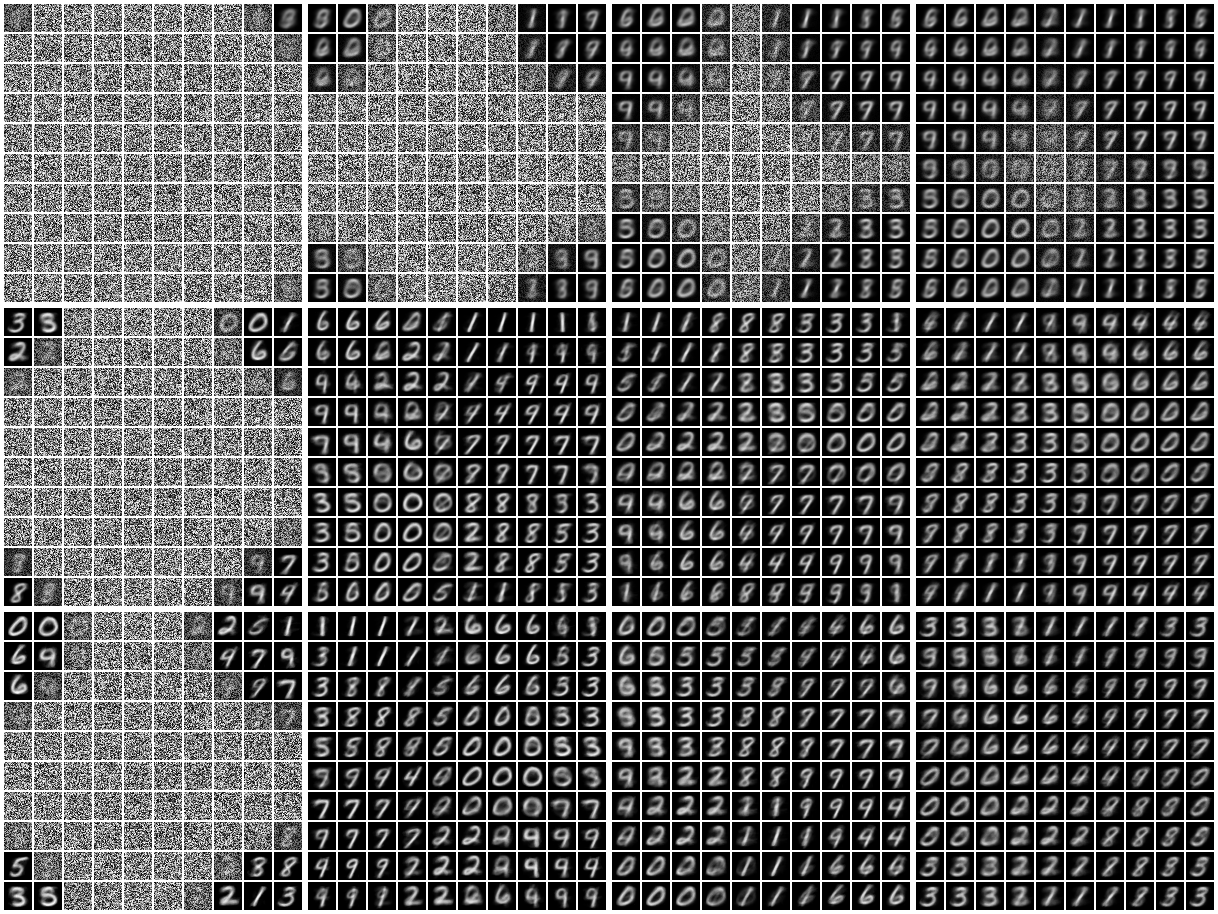

In [6]:
array_to_image(model.w_bu)